# Assignment 4 – Privacy-Preserving Federated Learning Simulation (Breast Cancer Dataset)

TODO: **Note: Although this is a breast cancer dataset, you should frame findings in a way that could be ported to SeleneX (e.g., how to handle site heterogeneity, privacy budgets, and model monitoring when we later swap in ovarian features).**

### Objective

Simulate federated learning across two “hospitals” using the Breast Cancer Wisconsin (Diagnostic) dataset without sharing raw data. Add a differential-privacy layer, compare against centralized training, and document privacy/utility trade-offs.

## 0. Imports & Setup

In [1]:
import torch, opacus, yaml, os, sys, random, joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import flwr as fl

from sklearn import datasets, model_selection, utils
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# -------------------------------- LOAD CONFIG ------------------------------- #
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# ---------------------------- DIRECTORY CREATION ---------------------------- #
# doc/ directory
docs_dir = os.path.join('..', config['directories']['docs'])
os.makedirs(docs_dir, exist_ok=True)

# Subdirectories for pyplot plots
pdf_dir = os.path.join(docs_dir, 'figures_as_pdf')
png_dir = os.path.join(docs_dir, 'figures_as_png')
os.makedirs(pdf_dir, exist_ok=True)
os.makedirs(png_dir, exist_ok=True)

data_dir = os.path.join('..', config['directories']['data'])
os.makedirs(data_dir, exist_ok=True)

# ---------------------- FIXED SEEDS FOR REPRODUCIBILITY --------------------- #
RANDOM_SEED = config['values']['RANDOM_SEED']
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

# ----------------------------- GPU AVAILABILITY ----------------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading and EDA (Centralized, Local Only)

### 1.1 Load with load_breast_cancer(return_X_y=True, as_frame=True)

In [2]:
# Load the breast cancer dataset
X_train: pd.DataFrame
y_train: pd.Series
X_train, y_train = datasets.load_breast_cancer(return_X_y=True, as_frame=True)    # type: ignore

In [3]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

### 1.2 Confirm target mapping (document “0=malignant, 1=benign” or vice-versa)

**0 = malignant, 1 = benign**

In [5]:
# Official target mapping
data = datasets.load_breast_cancer()  # this variable is deleted at the end of this cell
print("Official target names from dataset:", data.target_names)                                                                                 #type: ignore
print("Unique target values:", np.unique(data.target))                                                                                          #type: ignore

# Verify the mapping
print("\nOfficial label mapping:")
for i, name in enumerate(data.target_names):                                                                                                    #type: ignore
    count = (data.target == i).sum()                                                                                                            #type: ignore
    print(f"{i}: {name} - {count} samples")

assert len(data.target) == len(y_train), f"LENGTH MISMATCH: y_data has {len(y_train)} samples, but data.target has {len(data.target)} samples"    #type: ignore
print("\nPASS: Length of y_data matches the length of data.target")

del data # Clean up memory

Official target names from dataset: ['malignant' 'benign']
Unique target values: [0 1]

Official label mapping:
0: malignant - 212 samples
1: benign - 357 samples

PASS: Length of y_data matches the length of data.target


### 1.3 Basic EDA

In [6]:
def save_plot(fig, filename):
    """Save the plot to the specified directory with separate folders for PNG and PDF."""
    fig.savefig(os.path.join(png_dir, f"{filename}.png"), bbox_inches='tight')
    fig.savefig(os.path.join(pdf_dir, f"{filename}.pdf"), bbox_inches='tight')

**Class Balance**

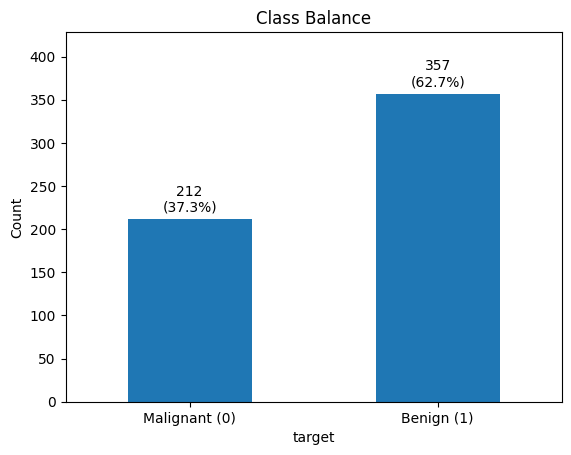

In [7]:
# Plots the class balance with counts and percentages
counts = y_train.value_counts().sort_index()
ax = counts.plot(kind='bar', title='Class Balance')
total = len(y_train)

for i, v in enumerate(counts):
    percentage = (v / total) * 100
    ax.text(i, v + 5, f'{v}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.xticks([0, 1], ['Malignant (0)', 'Benign (1)'], rotation=0)
plt.ylabel('Count')
plt.ylim(0, max(counts) * 1.2)

# Save the plot
save_plot(plt.gcf(), config['plots']['eda']['class_balance'])

plt.show()

**Feature Means/SD**

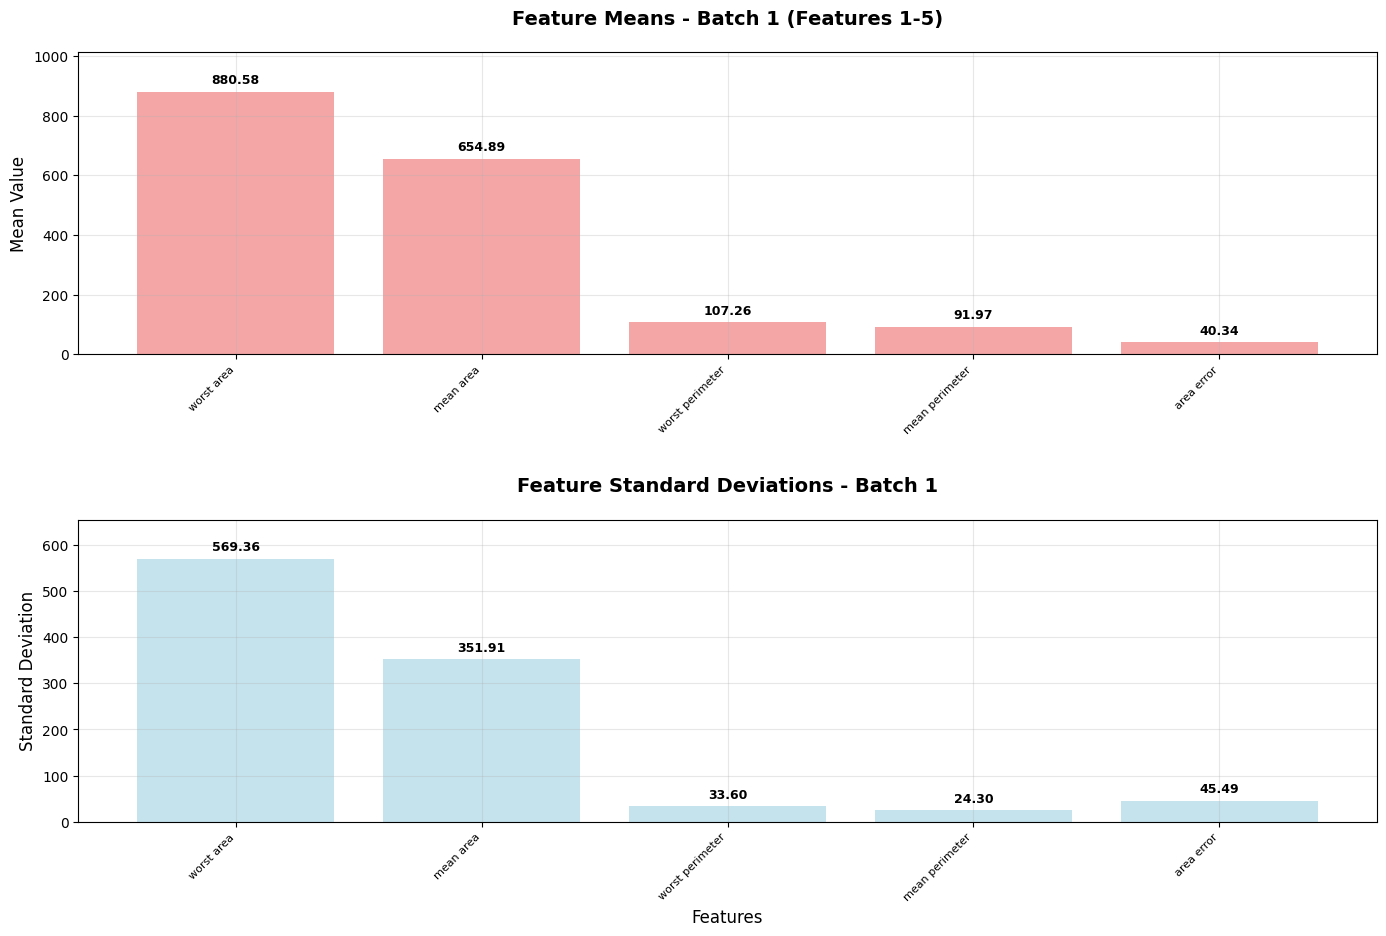

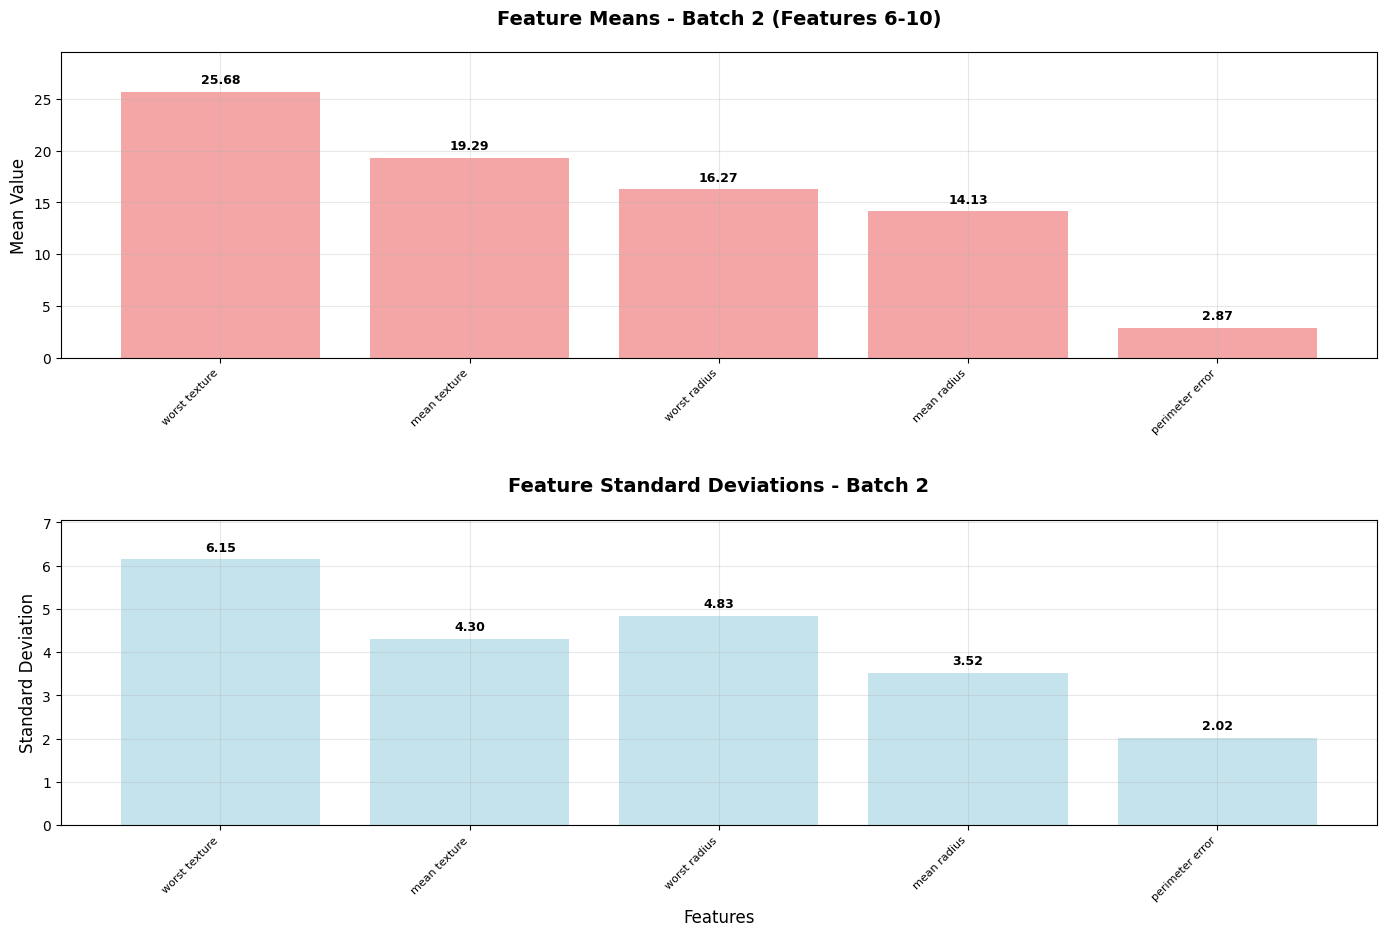

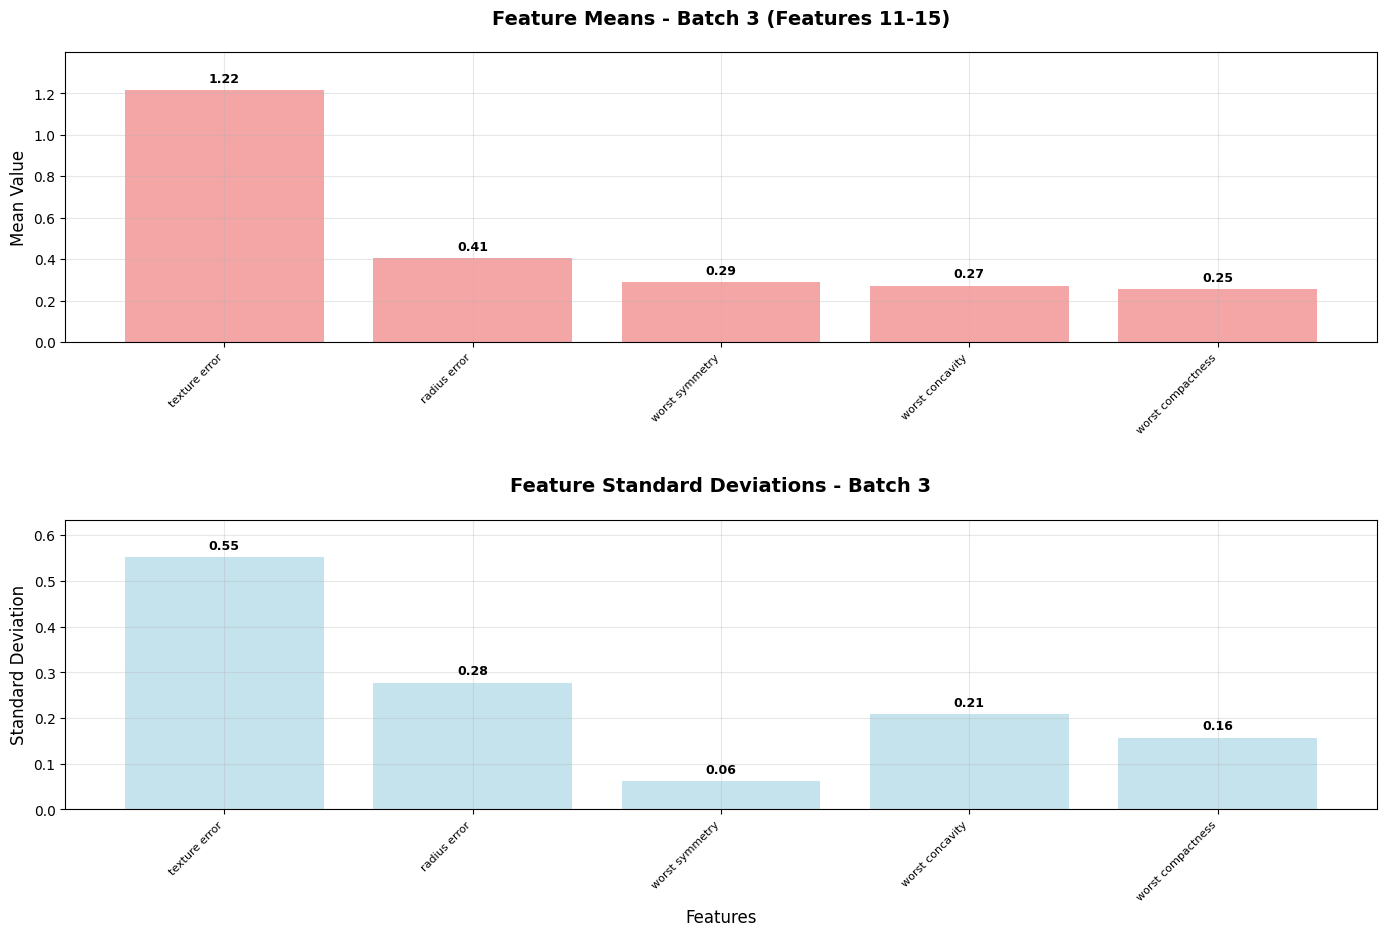

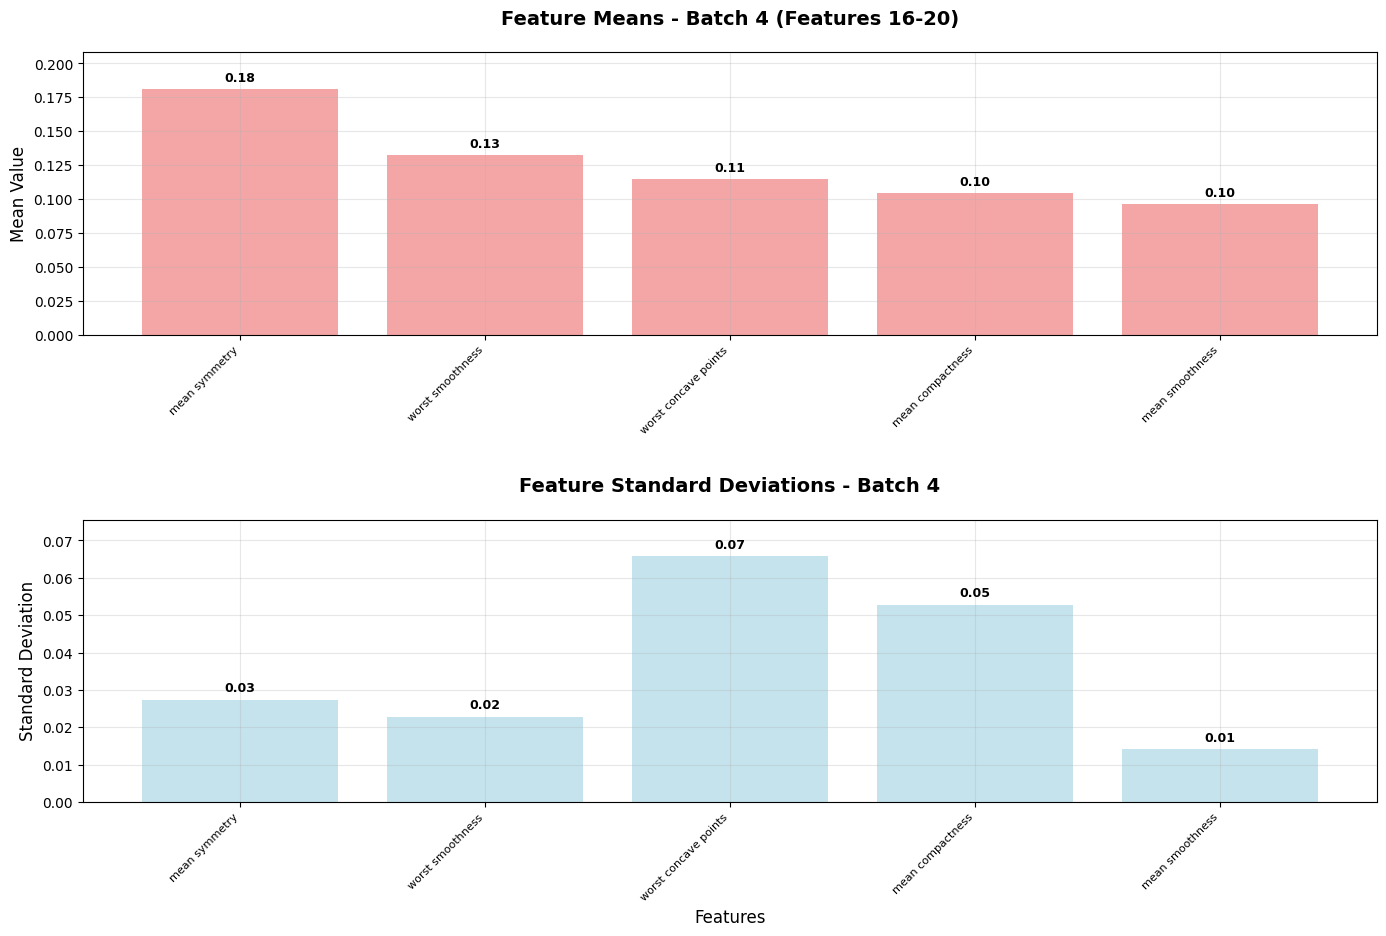

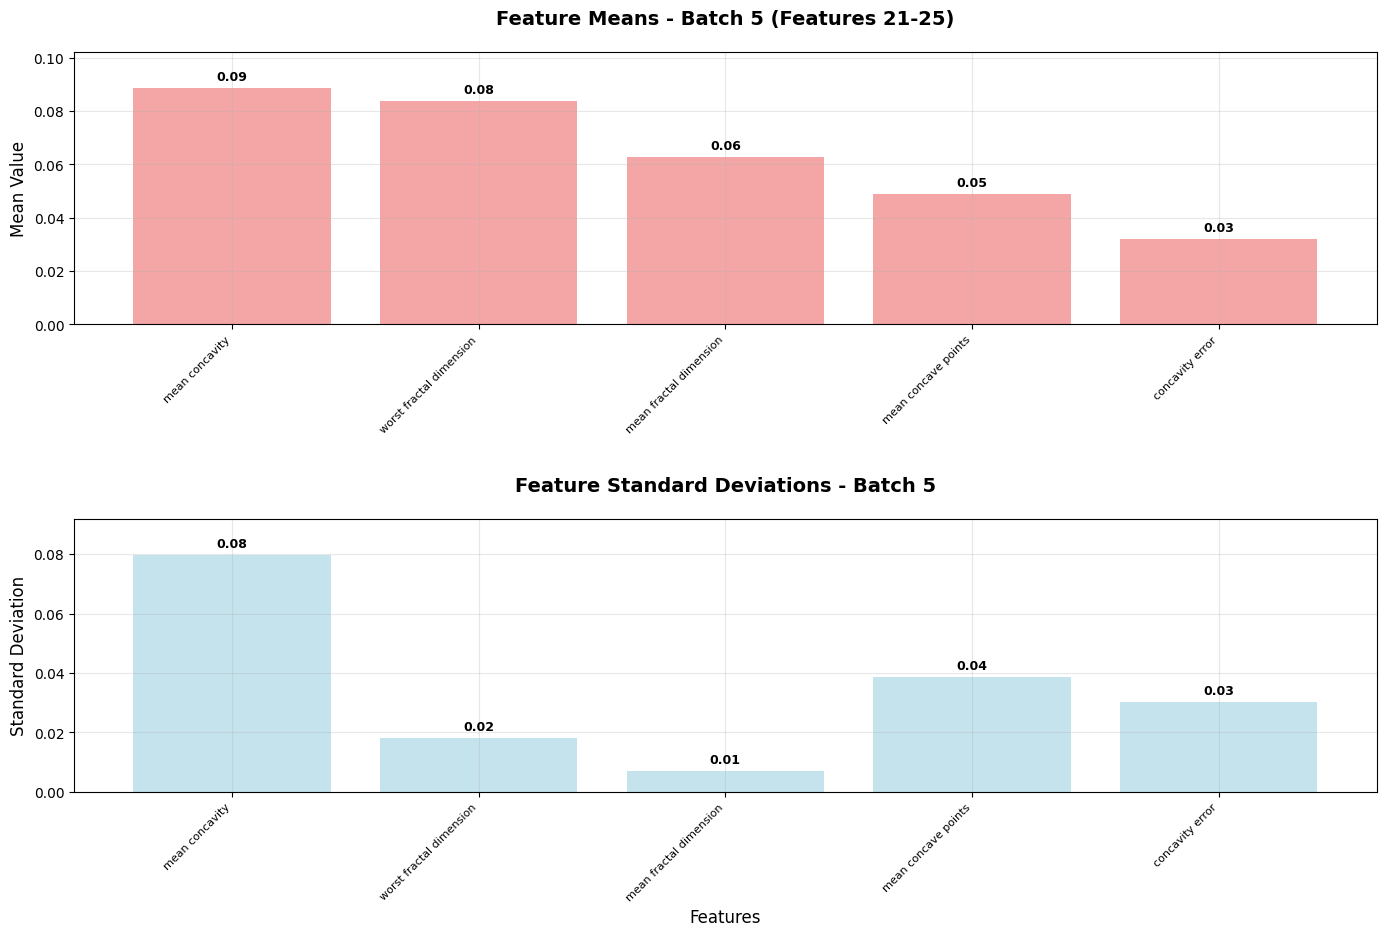

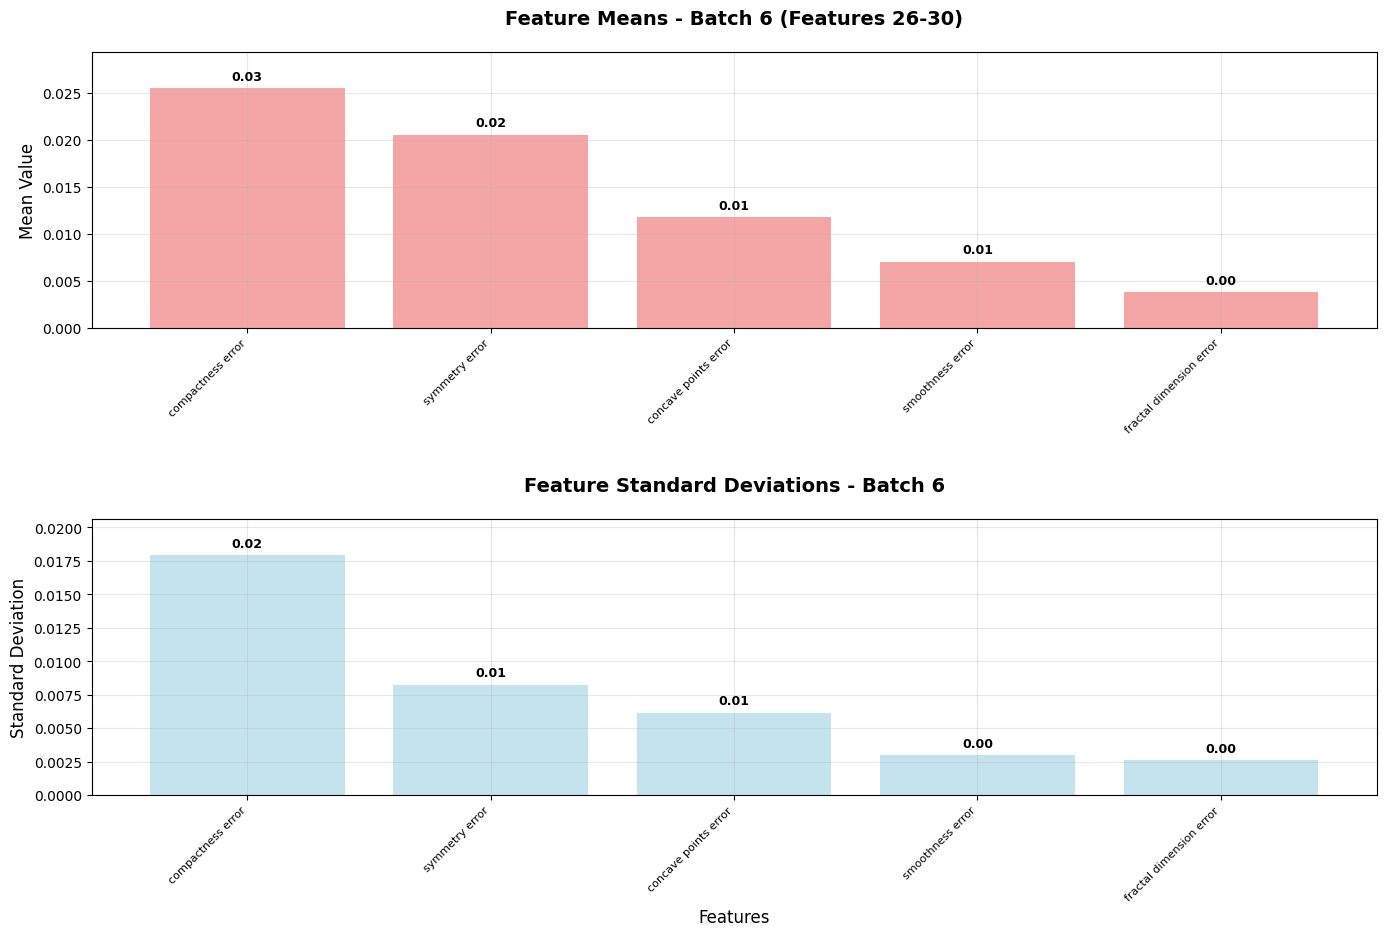

Feature Statistics Summary:
Number of features: 30
Number of batches created: 6

Means:
  Mean of means: 61.8907
  Std of means: 195.8614
  Min mean: 0.0038 (fractal dimension error)
  Max mean: 880.5831 (worst area)

Standard Deviations:
  Mean of SDs: 34.9047
  Std of SDs: 119.6758
  Min SD: 0.0026 (fractal dimension error)
  Max SD: 569.3570 (worst area)


In [8]:
# Feature means and standard deviations
feature_means = X_train.mean().sort_values(ascending=False)
feature_stds = X_train.std()

# Plot all features in batches of 5
batch_size = 5
num_features = len(feature_means)
num_batches = (num_features + batch_size - 1) // batch_size

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, num_features)
    
    # Features for this batch (maintain sorting order)
    batch_feature_names = feature_means.iloc[start_idx:end_idx].index
    batch_means = feature_means.iloc[start_idx:end_idx]
    batch_stds = feature_stds[batch_feature_names]  # SDs for same features
    
    # Dynamic figure sizing
    max_label_length = max(len(str(name)) for name in batch_feature_names)
    width = max(12, 2 + len(batch_feature_names) * 2.5)  # Dynamic width
    height = max(10, 2 + max_label_length * 0.3)  # Dynamic height for labels
    
    # Figure with subplots for this batch
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height))
    
    # -------------------------------- MEANS PLOT -------------------------------- #
    bars1 = ax1.bar(range(len(batch_means)), batch_means.values, color='lightcoral', alpha=0.7)
    ax1.set_title(f'Feature Means - Batch {batch_idx + 1} (Features {start_idx + 1}-{end_idx})', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Mean Value', fontsize=12)
    ax1.set_xticks(range(len(batch_means)))
    
    # Dynamic font sizing for x-axis labels
    label_fontsize = max(8, min(12, 120 // max_label_length))
    ax1.set_xticklabels(batch_means.index, rotation=45, ha='right', fontsize=label_fontsize)
    ax1.grid(True, alpha=0.3)
    
    # Automatic padding for means plot
    max_mean = max(batch_means.values)
    padding_mean = max_mean * 0.15  # 15% padding
    ax1.set_ylim(0, max_mean + padding_mean)
    
    # Value labels on mean bars
    for i, v in enumerate(batch_means.values):
        ax1.text(i, v + max_mean * 0.02, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=min(10, label_fontsize + 1), fontweight='bold')
    # ---------------------------------------------------------------------------- #

    # ------------------------- STANDARD DEVIATIONS PLOT ------------------------- #
    bars2 = ax2.bar(range(len(batch_stds)), batch_stds.values, color='lightblue', alpha=0.7)
    ax2.set_title(f'Feature Standard Deviations - Batch {batch_idx + 1}', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Features', fontsize=12)
    ax2.set_ylabel('Standard Deviation', fontsize=12)
    ax2.set_xticks(range(len(batch_stds)))
    ax2.set_xticklabels(batch_stds.index, rotation=45, ha='right', fontsize=label_fontsize)
    ax2.grid(True, alpha=0.3)
    
    # Automatic padding for standard deviations plot
    max_std = max(batch_stds.values)
    padding_std = max_std * 0.15  # 15% padding
    ax2.set_ylim(0, max_std + padding_std)
    
    # Value labels on SD bars
    for i, v in enumerate(batch_stds.values):
        ax2.text(i, v + max_std * 0.02, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=min(10, label_fontsize + 1), fontweight='bold')
    # ---------------------------------------------------------------------------- #

    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=1.5)

    # Save every plot
    save_plot(fig, f"{config['plots']['eda']['feature_means_std']}_batch_{batch_idx + 1}")
    
    plt.show()
    
# Means and SDs summary
print("Feature Statistics Summary:")
print(f"Number of features: {len(feature_means)}")
print(f"Number of batches created: {num_batches}")
print("\nMeans:")
print(f"  Mean of means: {feature_means.mean():.4f}")
print(f"  Std of means: {feature_means.std():.4f}")
print(f"  Min mean: {feature_means.min():.4f} ({feature_means.idxmin()})")
print(f"  Max mean: {feature_means.max():.4f} ({feature_means.idxmax()})")
print("\nStandard Deviations:")
print(f"  Mean of SDs: {feature_stds.mean():.4f}")
print(f"  Std of SDs: {feature_stds.std():.4f}")
print(f"  Min SD: {feature_stds.min():.4f} ({feature_stds.idxmin()})")
print(f"  Max SD: {feature_stds.max():.4f} ({feature_stds.idxmax()})")

**Correlation Heatmap**

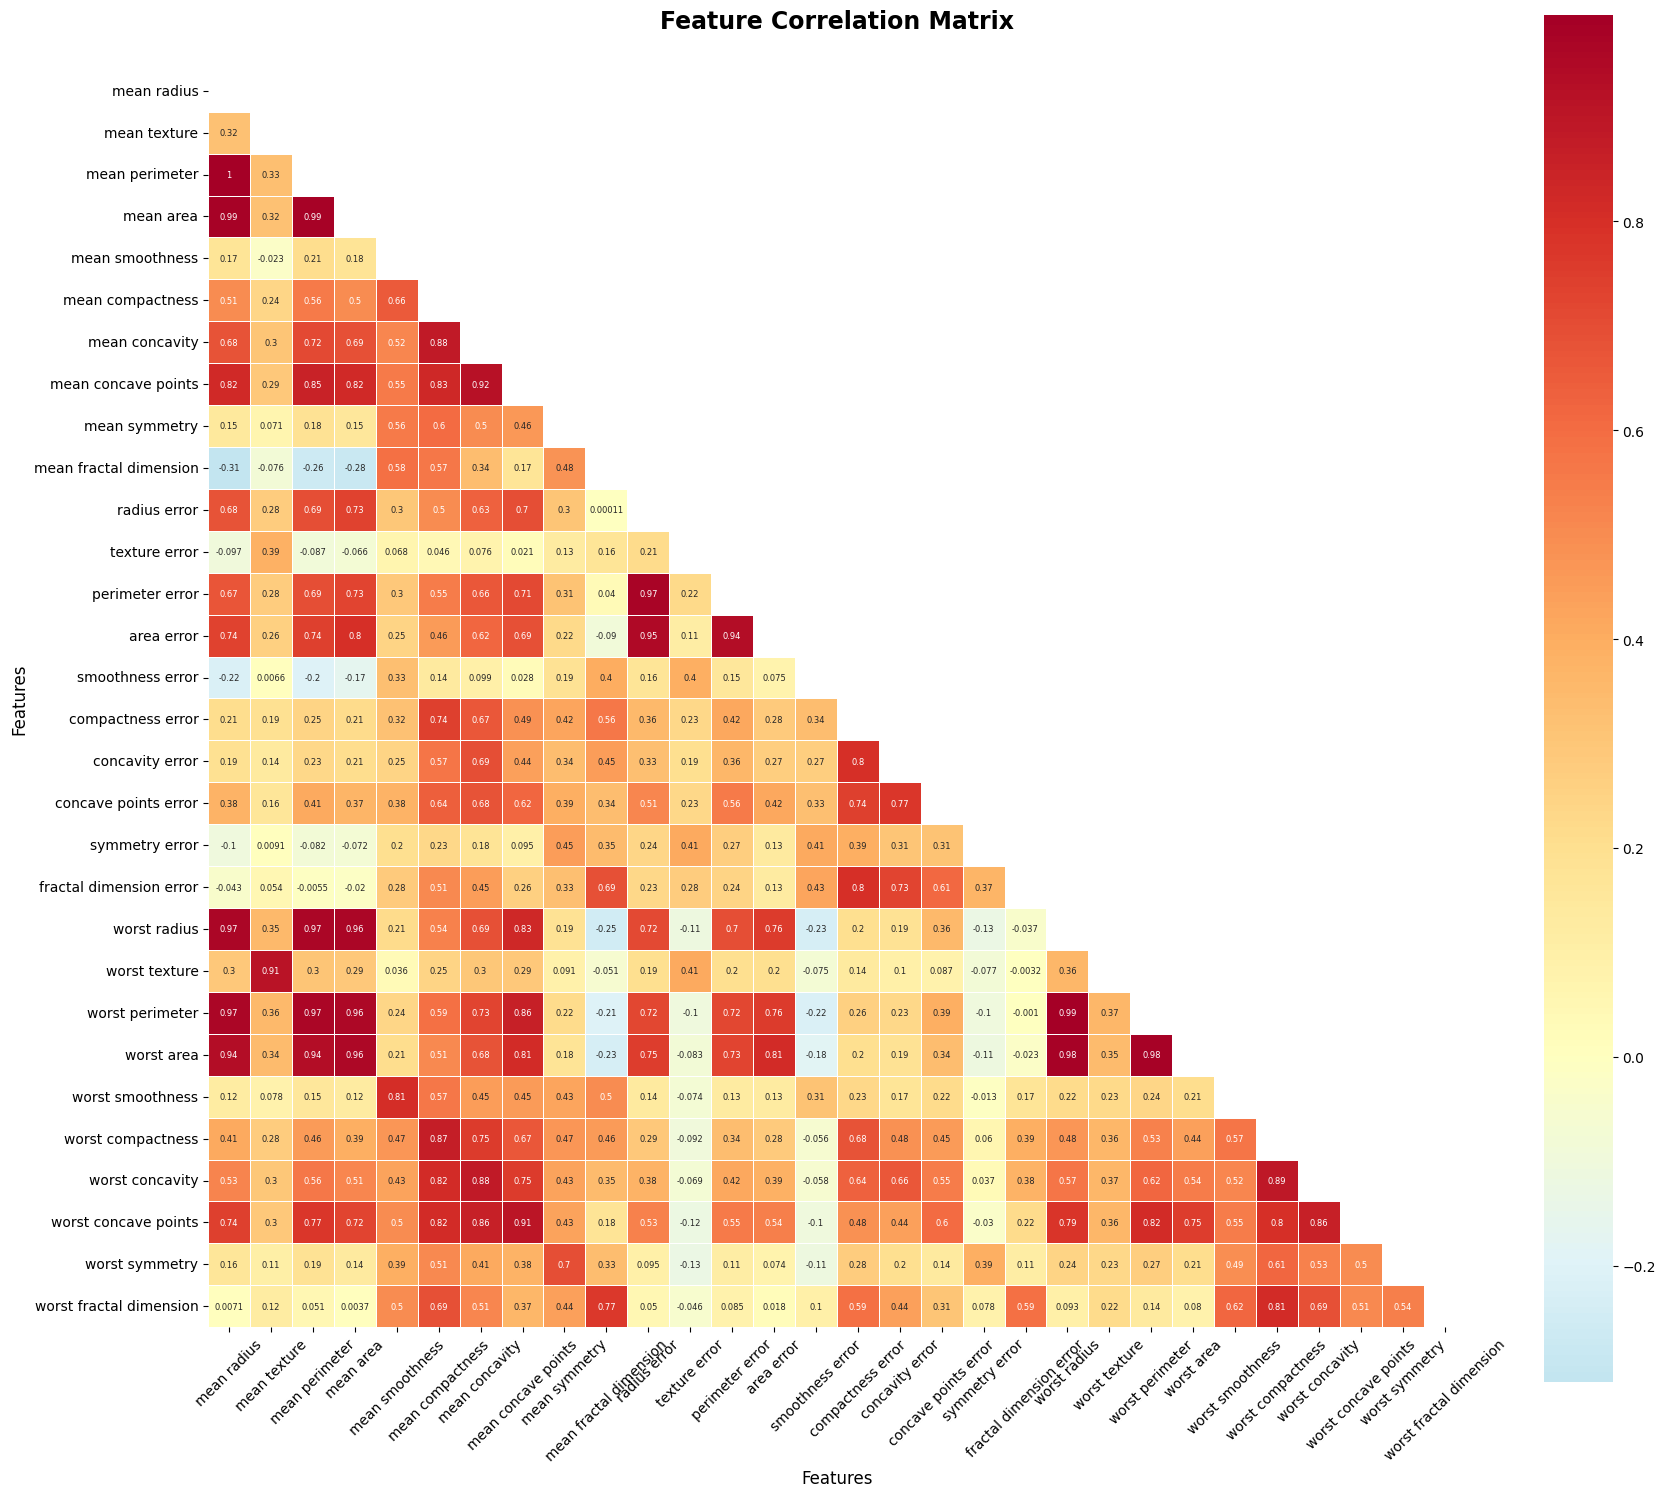

Correlation Analysis:
Highest positive correlation: 1.0000
Highest negative correlation: -0.3116

Highly Correlated Pairs: 44
mean radius <-> mean perimeter: 0.9979
worst radius <-> worst perimeter: 0.9937
mean radius <-> mean area: 0.9874
mean perimeter <-> mean area: 0.9865
worst radius <-> worst area: 0.9840
worst perimeter <-> worst area: 0.9776
radius error <-> perimeter error: 0.9728
mean perimeter <-> worst perimeter: 0.9704
mean radius <-> worst radius: 0.9695
mean perimeter <-> worst radius: 0.9695


In [9]:
# Correlation matrix
corr_matrix = X_train.corr()

# Dynamic sizing
num_features = len(corr_matrix.columns)
max_label_length = max(len(str(col)) for col in corr_matrix.columns)

base_size = max(16, num_features * 0.6)  # Base size scales with features
width = min(base_size, 25)  # Cap maximum width
height = min(base_size, 20)  # Cap maximum height

# Heatmap with dynamic sizing
fig, ax = plt.subplots(figsize=(width, height))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Ignore upper triangle

# Dynamic font sizes based on matrix size
annot_fontsize = max(4, min(8, 200 // num_features))
label_fontsize = max(8, min(12, 300 // max_label_length))

heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                      square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax,
                      annot_kws={"size": annot_fontsize})

plt.title('Feature Correlation Matrix', fontsize=min(18, 16 + width//10), fontweight='bold', pad=30)
plt.xlabel('Features', fontsize=label_fontsize)
plt.ylabel('Features', fontsize=label_fontsize)

# Enhanced tick label formatting
ax.tick_params(axis='x', labelsize=max(6, label_fontsize-2), rotation=45)
ax.tick_params(axis='y', labelsize=max(6, label_fontsize-2), rotation=0)

# Adjust margins for better label visibility
plt.subplots_adjust(bottom=0.25, left=0.25)
plt.tight_layout()

# Save the plot
save_plot(fig, config['plots']['eda']['correlation_heatmap'])

plt.show()

# Print some correlation insights
print("Correlation Analysis:")
print(f"Highest positive correlation: {corr_matrix.max().max():.4f}")
print(f"Highest negative correlation: {corr_matrix.min().min():.4f}")

# Find high correlation pairs (exclude self-correlation)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # High correlation threshold #type: ignore
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

print(f"\nHighly Correlated Pairs: {len(high_corr_pairs)}")
for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
    print(f"{feat1} <-> {feat2}: {corr_val:.4f}")

## 2. Create Two Non-IID Hospital Splits

### 2.1 Shuffle with Fixed Seed

In [10]:
X_shuffled, y_shuffled = utils.shuffle(X_train, y_train, random_state=RANDOM_SEED)    #type: ignore

**Verify Integrity of Feature-Target Pairs**

In [11]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [12]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [13]:
X_shuffled.head()   #type: ignore

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
421,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406,...,16.46,18.34,114.10,809.2,0.1312,0.36350,0.3219,0.11080,0.2827,0.09208
47,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,15.67,27.95,102.80,759.4,0.1786,0.41660,0.5006,0.20880,0.3900,0.11790
292,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,...,13.74,19.93,88.81,585.4,0.1483,0.20680,0.2241,0.10560,0.3380,0.09584
186,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,0.05425,...,21.31,26.36,139.20,1410.0,0.1234,0.24450,0.3538,0.15710,0.3206,0.06938
414,15.13,29.81,96.71,719.5,0.08320,0.04605,0.04686,0.02739,0.1852,0.05294,...,17.26,36.91,110.10,931.4,0.1148,0.09866,0.1547,0.06575,0.3233,0.06165


In [14]:
y_shuffled.head()   #type: ignore

421    1
47     0
292    1
186    0
414    0
Name: target, dtype: int64

### 2.2 External Test Split

In [15]:
# Split shuffled data into train (80%) and external test (20%)
X_train_full, X_test, y_train_full, y_test = model_selection.train_test_split(
    X_shuffled, y_shuffled, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    stratify=y_shuffled                                                                         #type: ignore
)

print(f"Full dataset size: {len(X_shuffled)}")                                                  #type: ignore
print(f"Training set size: {len(X_train_full)} ({len(X_train_full)/len(X_shuffled)*100:.1f}%)") #type: ignore
print(f"External test set size: {len(X_test)} ({len(X_test)/len(X_shuffled)*100:.1f}%)")        #type: ignore

print(f"\nClass distribution in test set:")
test_counts = y_test.value_counts().sort_index()
print(f" Malignant (0): {test_counts[0]} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f" Benign (1): {test_counts[1]} ({test_counts[1]/len(y_test)*100:.1f}%)")

Full dataset size: 569
Training set size: 455 (80.0%)
External test set size: 114 (20.0%)

Class distribution in test set:
 Malignant (0): 42 (36.8%)
 Benign (1): 72 (63.2%)


### 2.3 Creating Data Shards Using Feature Shift (Option B)

According to the correlation matrix, ```mean radius``` feature has the highest correlation. Therefore, feature shift will be done based on ```mean radius```.

Threshold strategy is mean + (std / 2) of ```mean radius```.

In [16]:
# Data shards from the training data
feature_for_feature_shift = config['values']['FEATURE_SHIFT']
threshold = X_train_full[feature_for_feature_shift].mean() + X_train_full[feature_for_feature_shift].std() / 2
print(f"\nFeature for feature shift: {feature_for_feature_shift}")
print(f"Feature shift threshold: {threshold}")

# Shards based on mean radius threshold
high_radius_mask = X_train_full[feature_for_feature_shift] > threshold

# High shard: mean radius > threshold
high_shard_X = X_train_full[high_radius_mask]
high_shard_y = y_train_full[high_radius_mask]

# Low shard: mean radius <= threshold
low_radius_mask = X_train_full[feature_for_feature_shift] <= threshold
low_shard_X = X_train_full[low_radius_mask]
low_shard_y = y_train_full[low_radius_mask]

# Print shard sizes
print(f"\nHigh Shard Size: {len(high_shard_X)} ({len(high_shard_X)/len(X_train_full)*100:.1f}%)")
print(f"Low Shard Size: {len(low_shard_X)} ({len(low_shard_X)/len(X_train_full)*100:.1f}%)")


Feature for feature shift: mean radius
Feature shift threshold: 15.88119472499265

High Shard Size: 108 (23.7%)
Low Shard Size: 347 (76.3%)


### 2.4 Combine Shards with Their Targets

In [17]:
hospital_a = high_shard_X.copy()
hospital_a['target'] = high_shard_y

hospital_b = low_shard_X.copy()
hospital_b['target'] = low_shard_y

test_df = X_test.copy()
test_df['target'] = y_test

### 2.5 Check Data Leakage Among All Sets

In [18]:
# Get indices for each dataset
hospital_a_indices = set(hospital_a.index)
hospital_b_indices = set(hospital_b.index)
test_indices = set(test_df.index)

print("Dataset Sizes:")
print(f" Hospital A: {len(hospital_a_indices)} samples")
print(f" Hospital B: {len(hospital_b_indices)} samples")
print(f" Test Set: {len(test_indices)} samples")
print(f" Total: {len(hospital_a_indices) + len(hospital_b_indices) + len(test_indices)} samples")

# ----------------------- CHECK FOR OVERLAPPING INDICES ---------------------- #
print("\nOverlaps:")
# Hospital A vs Hospital B
overlap_a_b = hospital_a_indices.intersection(hospital_b_indices)
print(f" Hospital A ∩ Hospital B: {len(overlap_a_b)} samples")
if len(overlap_a_b) > 0:
    print(f"  LEAKAGE DETECTED: {list(overlap_a_b)[:10]}")

# Hospital A vs Test Set
overlap_a_test = hospital_a_indices.intersection(test_indices)
print(f" Hospital A ∩ Test Set: {len(overlap_a_test)} samples")
if len(overlap_a_test) > 0:
    print(f"  LEAKAGE DETECTED: {list(overlap_a_test)[:10]}")

# Hospital B vs Test Set
overlap_b_test = hospital_b_indices.intersection(test_indices)
print(f" Hospital B ∩ Test Set: {len(overlap_b_test)} samples")
if len(overlap_b_test) > 0:
    print(f"  LEAKAGE DETECTED: {list(overlap_b_test)[:10]}")

# Three-way overlap
overlap_all = hospital_a_indices.intersection(hospital_b_indices).intersection(test_indices)
print(f" All three datasets: {len(overlap_all)} samples")
if len(overlap_all) > 0:
    print(f"  CRITICAL LEAKAGE: {list(overlap_all)}")

# Union check - should equal original dataset size
total_unique = len(hospital_a_indices.union(hospital_b_indices).union(test_indices))
original_size = len(X_shuffled)  #type: ignore

print(f"\nTotal unique samples across all splits: {total_unique}")
print(f"Original dataset size: {original_size}")
print(f"All samples accounted for: {total_unique == original_size}")
# ---------------------------------------------------------------------------- #

# ---------------------------------- RESULTS --------------------------------- #
total_overlaps = len(overlap_a_b) + len(overlap_a_test) + len(overlap_b_test) + len(overlap_all)
if total_overlaps == 0:
    print("=== PASS - NO DATA LEAKAGE ===")
else:
    raise ValueError(f"=== DATA LEAKAGE DETECTED - {total_overlaps} total overlapping instances found ===")
# ---------------------------------------------------------------------------- #

Dataset Sizes:
 Hospital A: 108 samples
 Hospital B: 347 samples
 Test Set: 114 samples
 Total: 569 samples

Overlaps:
 Hospital A ∩ Hospital B: 0 samples
 Hospital A ∩ Test Set: 0 samples
 Hospital B ∩ Test Set: 0 samples
 All three datasets: 0 samples

Total unique samples across all splits: 569
Original dataset size: 569
All samples accounted for: True
=== PASS - NO DATA LEAKAGE ===


### 2.6 Exporting the Data Splits

In [19]:
# Corresponding paths
hospital_a_path = os.path.join(data_dir, config['values']['hospital_a_export'])
hospital_b_path = os.path.join(data_dir, config['values']['hospital_b_export'])
test_path = os.path.join(data_dir, config['values']['test_set_export'])

# Export to CSV
hospital_a.to_csv(hospital_a_path, index=False)
hospital_b.to_csv(hospital_b_path, index=False)
test_df.to_csv(test_path, index=False)

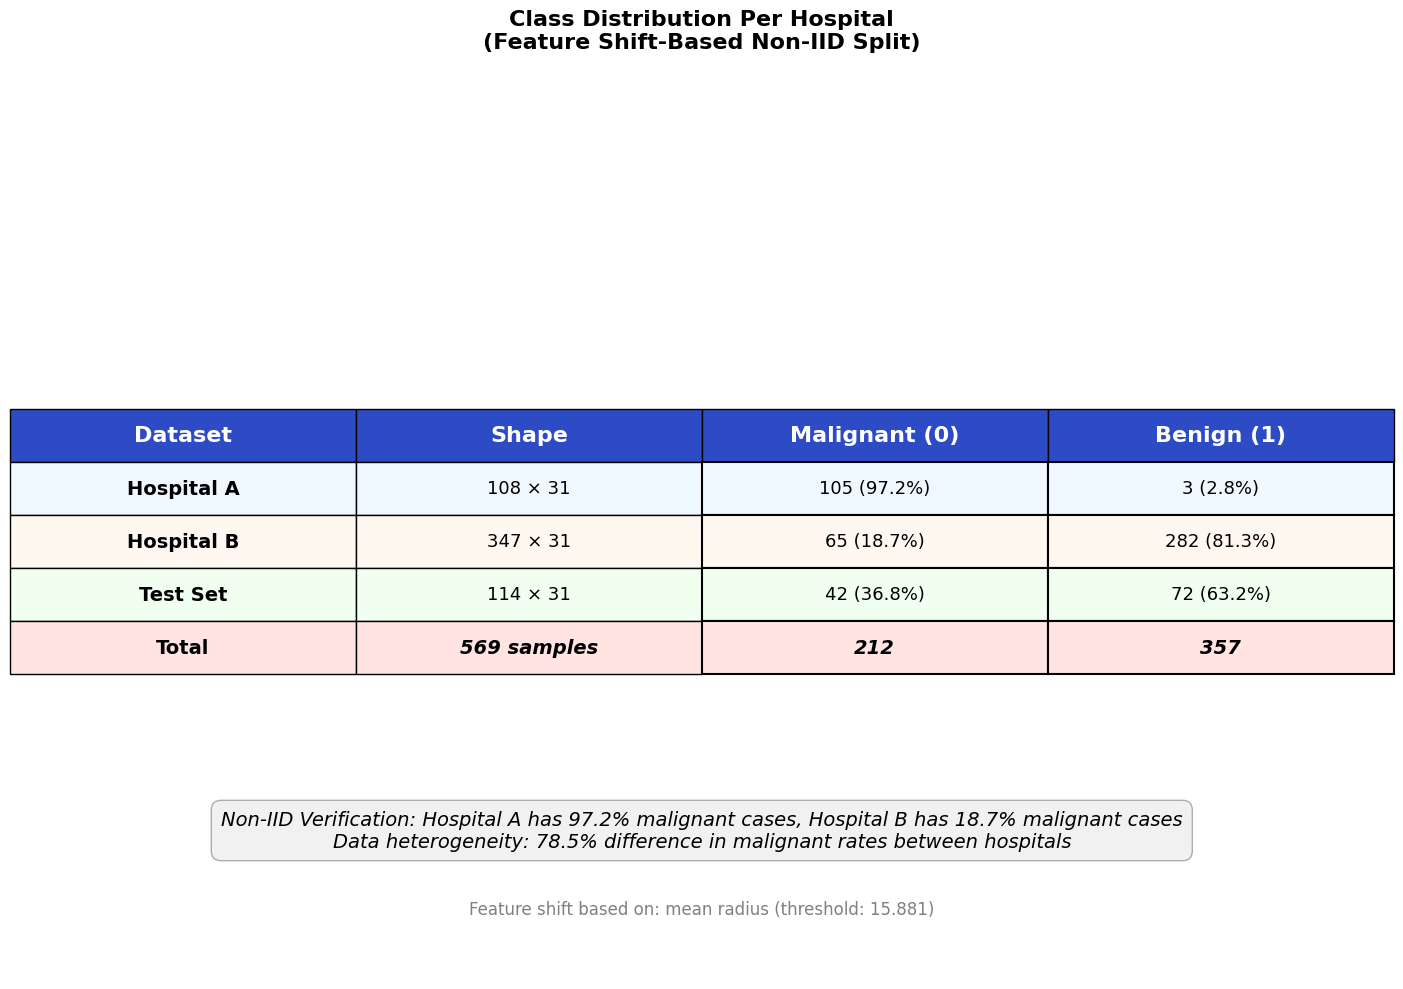

In [20]:
# Class distributions
hospital_a_malignant = len(hospital_a[hospital_a['target']==0])
hospital_a_benign = len(hospital_a[hospital_a['target']==1])
hospital_a_total = hospital_a.shape[0]

hospital_b_malignant = len(hospital_b[hospital_b['target']==0])
hospital_b_benign = len(hospital_b[hospital_b['target']==1])
hospital_b_total = hospital_b.shape[0]

test_malignant = len(test_df[test_df['target']==0])
test_benign = len(test_df[test_df['target']==1])
test_total = test_df.shape[0]

# Summary table
export_summary = {
    'Dataset': ['Hospital A', 'Hospital B', 'Test Set', 'Total'],
    'Shape': [
        f"{hospital_a.shape[0]} × {hospital_a.shape[1]}",
        f"{hospital_b.shape[0]} × {hospital_b.shape[1]}",
        f"{test_df.shape[0]} × {test_df.shape[1]}",
        f"{hospital_a_total + hospital_b_total + test_total} samples"
    ],
    'Malignant (0)': [
        f"{hospital_a_malignant} ({hospital_a_malignant/hospital_a_total*100:.1f}%)",
        f"{hospital_b_malignant} ({hospital_b_malignant/hospital_b_total*100:.1f}%)",
        f"{test_malignant} ({test_malignant/test_total*100:.1f}%)",
        f"{hospital_a_malignant + hospital_b_malignant + test_malignant}"
    ],
    'Benign (1)': [
        f"{hospital_a_benign} ({hospital_a_benign/hospital_a_total*100:.1f}%)",
        f"{hospital_b_benign} ({hospital_b_benign/hospital_b_total*100:.1f}%)",
        f"{test_benign} ({test_benign/test_total*100:.1f}%)",
        f"{hospital_a_benign + hospital_b_benign + test_benign}"
    ]
}

export_df = pd.DataFrame(export_summary)

# Non-IID verification
malignant_rate_a = hospital_a_malignant/hospital_a_total*100
malignant_rate_b = hospital_b_malignant/hospital_b_total*100

# -------------------------------- TABLE PLOT -------------------------------- #
# Dynamic sizing
num_rows = len(export_df)
num_cols = len(export_df.columns)
max_content_length = max([max(len(str(cell)) for cell in export_df[col]) for col in export_df.columns])

width = max(14, num_cols * 3 + max_content_length * 0.1)
height = max(8, num_rows * 1.5 + 4)  # Extra space for titles and subtitles

fig, ax = plt.subplots(figsize=(width, height))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=export_df.values,     #type: ignore
                colLabels=export_df.columns,    #type: ignore
                cellLoc='center',
                loc='center')

# Dynamic font sizing and table scaling
base_fontsize = max(10, min(14, 300 // max_content_length))
table.auto_set_font_size(False)
table.set_fontsize(base_fontsize)

# Dynamic table scaling
scale_factor = max(1.2, min(2.5, width / 14))
table.scale(scale_factor, 2.8)

# Header styling
header_color = '#2E4BC6'
header_fontsize = min(base_fontsize + 2, 16)
for i in range(len(export_df.columns)):
    table[(0, i)].set_facecolor(header_color)
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=header_fontsize)

# Row styling, alternating colors and highlighting
row_colors = ['#F0F8FF', '#FFF8F0', '#F0FFF0', '#FFE4E1']

for i in range(1, len(export_df) + 1):
    # Name column
    table[(i, 0)].set_facecolor(row_colors[i-1])
    table[(i, 0)].set_text_props(weight='bold', fontsize=base_fontsize)
    
    # Other columns
    for j in range(1, len(export_df.columns)):
        table[(i, j)].set_facecolor(row_colors[i-1])
        table[(i, j)].set_text_props(fontsize=base_fontsize - 1)
        
        # Highlight the total row differently
        if i == 4:
            table[(i, j)].set_text_props(weight='bold', style='italic', fontsize=base_fontsize)
        
        # Malignant and Benign columns border styling
        if j in [2, 3]:  # Malignant and Benign columns
            table[(i, j)].set_edgecolor('black')
            table[(i, j)].set_linewidth(1.5)

# Title
title_fontsize = max(16, min(20, width))
plt.title('Class Distribution Per Hospital\n(Feature Shift-Based Non-IID Split)', 
          fontsize=title_fontsize, fontweight='bold', pad=40)

# Subtitle
subtitle = f"""Non-IID Verification: Hospital A has {malignant_rate_a:.1f}% malignant cases, Hospital B has {malignant_rate_b:.1f}% malignant cases
Data heterogeneity: {abs(malignant_rate_a - malignant_rate_b):.1f}% difference in malignant rates between hospitals"""

subtitle_fontsize = max(10, min(14, base_fontsize))
plt.figtext(0.5, 0.15, subtitle, ha='center', fontsize=subtitle_fontsize, style='italic', 
            wrap=True, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.3))

# Feature shift note
note_fontsize = max(8, min(12, base_fontsize - 2))
plt.figtext(0.5, 0.08, f'Feature shift based on: {config["values"]["FEATURE_SHIFT"]} (threshold: {threshold:.3f})', 
            ha='center', fontsize=note_fontsize, color='gray')

plt.subplots_adjust(top=0.85, bottom=0.25)
plt.tight_layout()

# Save the plot
save_plot(fig, config['plots']['non_iid_split']['class_distribution_per_hospital'])

plt.show()

## 3. Baseline Centralised Model

This is the baseline model with centralised learning. A Logistic Regression (LR) and a RandomForestClassifier (RF) will be trained for comparison.

Best model will be selected for further comparison with FD models.

### 3.1 Combine Data Shards

In [21]:
h_a = pd.read_csv("../data/hospital_a.csv", index_col=None)
h_b = pd.read_csv("../data/hospital_b.csv", index_col=None)

print("Hospital A Shape:" + str(h_a.shape))
print("Hospital B Shape:" + str(h_b.shape))

df = pd.concat([h_a, h_b], ignore_index=True) 

print("Combined Data Shape: " + str(df.shape))
if(h_a.shape[0] + h_b.shape[0] == df.shape[0]):
    print("=== PASS - No missing values ===")
else:
    raise ValueError("=== ERROR - Missing values detected ===")

df.head()

Hospital A Shape:(108, 31)
Hospital B Shape:(347, 31)
Combined Data Shape: (455, 31)
=== PASS - No missing values ===


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,19.17,24.80,132.4,1123.0,0.09740,0.24580,0.2065,0.11180,0.2397,0.07800,...,29.94,151.7,1332.0,0.1037,0.3903,0.3639,0.1767,0.3176,0.10230,0
1,23.21,26.97,153.5,1670.0,0.09509,0.16820,0.1950,0.12370,0.1909,0.06309,...,34.51,206.0,2944.0,0.1481,0.4126,0.5820,0.2593,0.3103,0.08677,0
2,19.18,22.49,127.5,1148.0,0.08523,0.14280,0.1114,0.06772,0.1767,0.05529,...,32.06,166.4,1688.0,0.1322,0.5601,0.3865,0.1708,0.3193,0.09221,0
3,17.01,20.26,109.7,904.3,0.08772,0.07304,0.0695,0.05390,0.2026,0.05223,...,25.05,130.0,1210.0,0.1111,0.1486,0.1932,0.1096,0.3275,0.06469,0
4,17.20,24.52,114.2,929.4,0.10710,0.18300,0.1692,0.07944,0.1927,0.06487,...,33.82,151.6,1681.0,0.1585,0.7394,0.6566,0.1899,0.3313,0.13390,0


### 3.2 Train / Validation Split

In [22]:
X_combined = df.drop('target', axis=1)
y_combined = df['target']

X_train_central, X_val_central, y_train_central, y_val_central = model_selection.train_test_split(
    X_combined, y_combined,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_combined
)

print(f"Combined dataset size: {len(df)}")
print(f"Training set size: {len(X_train_central)} ({len(X_train_central)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val_central)} ({len(X_val_central)/len(df)*100:.1f}%)")

# Class distribution in splits
print(f"\nClass Distribution - Training Set:")
train_counts = y_train_central.value_counts().sort_index()
print(f" Malignant (0): {train_counts[0]} ({train_counts[0]/len(y_train_central)*100:.1f}%)")
print(f" Benign (1): {train_counts[1]} ({train_counts[1]/len(y_train_central)*100:.1f}%)")

print(f"\nClass Distribution - Validation Set:")
val_counts = y_val_central.value_counts().sort_index()
print(f" Malignant (0): {val_counts[0]} ({val_counts[0]/len(y_val_central)*100:.1f}%)")
print(f" Benign (1): {val_counts[1]} ({val_counts[1]/len(y_val_central)*100:.1f}%)")

Combined dataset size: 455
Training set size: 364 (80.0%)
Validation set size: 91 (20.0%)

Class Distribution - Training Set:
 Malignant (0): 136 (37.4%)
 Benign (1): 228 (62.6%)

Class Distribution - Validation Set:
 Malignant (0): 34 (37.4%)
 Benign (1): 57 (62.6%)


### 3.3 Logistic Regression Model

In [23]:
# Feature scaling
scaler = StandardScaler()
X_train_central_scaled = scaler.fit_transform(X_train_central)
X_val_central_scaled = scaler.transform(X_val_central)

# Initiate LR
lr_model = LogisticRegression(
    random_state=RANDOM_SEED,
    max_iter=1000,
    solver='liblinear' # 'liblinear' is suitable for small datasets and binary classification
)

# Train
lr_model.fit(X_train_central_scaled, y_train_central)

# Predict
y_train_pred_lr = lr_model.predict(X_train_central_scaled)
y_val_pred_lr = lr_model.predict(X_val_central_scaled)

# Prediction accuracies
train_acc_lr = accuracy_score(y_train_central, y_train_pred_lr)
val_acc_lr = accuracy_score(y_val_central, y_val_pred_lr)

print("Logistic Regression Results:")
print(f" Training Accuracy: {train_acc_lr:.4f}")
print(f" Validation Accuracy: {val_acc_lr:.4f}")
print(f" Overfitting Gap: {train_acc_lr - val_acc_lr:.4f}")

# Classification report
print("\nValidation Classification Report:")
print(classification_report(y_val_central, y_val_pred_lr, target_names=['Malignant', 'Benign']))

# Confusion matrix
cm_lr = confusion_matrix(y_val_central, y_val_pred_lr)
print("\nValidation Confusion Matrix:")
print(cm_lr)

# Feature importance (coefficients)
feature_names = X_train_central.columns
coefficients = lr_model.coef_[0]
feature_importance_lr = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_lr.head(10).to_string(index=False))

Logistic Regression Results:
 Training Accuracy: 0.9918
 Validation Accuracy: 0.9890
 Overfitting Gap: 0.0027

Validation Classification Report:
              precision    recall  f1-score   support

   Malignant       1.00      0.97      0.99        34
      Benign       0.98      1.00      0.99        57

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91


Validation Confusion Matrix:
[[33  1]
 [ 0 57]]

Top 10 Most Important Features:
             Feature  Coefficient  Abs_Coefficient
        radius error    -1.241475         1.241475
          worst area    -1.025669         1.025669
          area error    -1.008896         1.008896
        worst radius    -1.002857         1.002857
       worst texture    -0.957488         0.957488
     worst perimeter    -0.850944         0.850944
     worst concavity    -0.829236         0.829236
worst concave points    -0.815817     

### 3.4 Random Forest Classifier Model

In [24]:
# Initialize RF
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

# Train
rf_model.fit(X_train_central, y_train_central)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_central)
y_val_pred_rf = rf_model.predict(X_val_central)

# Prediction accuracies
train_acc_rf = accuracy_score(y_train_central, y_train_pred_rf)
val_acc_rf = accuracy_score(y_val_central, y_val_pred_rf)

print("Random Forest Results:")
print(f" Training Accuracy: {train_acc_rf:.4f}")
print(f" Validation Accuracy: {val_acc_rf:.4f}")
print(f" Overfitting Gap: {train_acc_rf - val_acc_rf:.4f}")

# Classification report
print("\nValidation Classification Report:")
print(classification_report(y_val_central, y_val_pred_rf, target_names=['Malignant', 'Benign']))

# Confusion matrix
cm_rf = confusion_matrix(y_val_central, y_val_pred_rf)
print("\nValidation Confusion Matrix:")
print(cm_rf)

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_central.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(10).to_string(index=False))

Random Forest Results:
 Training Accuracy: 0.9918
 Validation Accuracy: 0.9670
 Overfitting Gap: 0.0247

Validation Classification Report:
              precision    recall  f1-score   support

   Malignant       0.94      0.97      0.96        34
      Benign       0.98      0.96      0.97        57

    accuracy                           0.97        91
   macro avg       0.96      0.97      0.96        91
weighted avg       0.97      0.97      0.97        91


Validation Confusion Matrix:
[[33  1]
 [ 2 55]]

Top 10 Most Important Features:
             Feature  Importance
worst concave points    0.126086
          worst area    0.118529
     worst perimeter    0.109953
        worst radius    0.106041
 mean concave points    0.094900
         mean radius    0.073318
      mean perimeter    0.065334
      mean concavity    0.056181
           mean area    0.046997
          area error    0.032656


### 3.5 Compare LR & RF Validation Set Results

In [25]:
print("Model Comparison on Validation Set")
print(f" Logistic Regression - Validation Accuracy: {val_acc_lr:.4f}")
print(f" Random Forest - Validation Accuracy: {val_acc_rf:.4f}")

if val_acc_rf > val_acc_lr:
    best_model = "Random Forest"
    best_val_acc = val_acc_rf
else:
    best_model = "Logistic Regression" 
    best_val_acc = val_acc_lr

print(f"\nBest model: {best_model} with validation accuracy: {best_val_acc:.4f}")

Model Comparison on Validation Set
 Logistic Regression - Validation Accuracy: 0.9890
 Random Forest - Validation Accuracy: 0.9670

Best model: Logistic Regression with validation accuracy: 0.9890


### 3.6 LR & RF on Test Set

In [26]:
# External test set
test_data = pd.read_csv(f"{data_dir}{config['values']['test_set_export']}")
X_test_final = test_data.drop('target', axis=1)
y_test_final = test_data['target']

print(f"Test set size: {len(X_test_final)}")
print(f"\nTest set class distribution:")

test_counts = y_test_final.value_counts().sort_index()
print(f" Malignant (0): {test_counts[0]} ({test_counts[0]/len(y_test_final)*100:.1f}%)")
print(f" Benign (1): {test_counts[1]} ({test_counts[1]/len(y_test_final)*100:.1f}%)")

# ------------------------- LOGISTIC REGRESSION TEST ------------------------- #
# Scale with the same scaler
X_test_final_scaled = scaler.transform(X_test_final)

# Predictions
y_test_pred_lr = lr_model.predict(X_test_final_scaled)
test_acc_lr = accuracy_score(y_test_final, y_test_pred_lr)

print("\nLogistic Regression Test Set Results:")
print(f" Test Accuracy: {test_acc_lr:.4f}")
print(f" Training Accuracy: {train_acc_lr:.4f}")
print(f" Validation Accuracy: {val_acc_lr:.4f}")
print(f" Generalization Gap (Train-Test): {train_acc_lr - test_acc_lr:.4f}")
print(f" Validation vs Test Gap: {val_acc_lr - test_acc_lr:.4f}")

# Classification report
print("\nLR Test Set Classification Report:")
print(classification_report(y_test_final, y_test_pred_lr, target_names=['Malignant', 'Benign']))

# Confusion matrix
print("\nLR Test Set Confusion Matrix:")
cm_lr_test = confusion_matrix(y_test_final, y_test_pred_lr)
print(cm_lr_test)
# ---------------------------------------------------------------------------- #

# ---------------------------- RANDOM FOREST TEST ---------------------------- #
# Predictions
y_test_pred_rf = rf_model.predict(X_test_final)
test_acc_rf = accuracy_score(y_test_final, y_test_pred_rf)

print("\nRandom Forest Test Set Results:")
print(f" Test Accuracy: {test_acc_rf:.4f}")
print(f" Training Accuracy: {train_acc_rf:.4f}")
print(f" Validation Accuracy: {val_acc_rf:.4f}")
print(f" Generalization Gap (Train-Test): {train_acc_rf - test_acc_rf:.4f}")
print(f" Validation vs Test Gap: {val_acc_rf - test_acc_rf:.4f}")

# Classification report
print("\nRF Test Set Classification Report:")
print(classification_report(y_test_final, y_test_pred_rf, target_names=['Malignant', 'Benign']))

# Confusion matrix
print("\nRF Test Set Confusion Matrix:")
cm_rf_test = confusion_matrix(y_test_final, y_test_pred_rf)
print(cm_rf_test)
# ---------------------------------------------------------------------------- #

Test set size: 114

Test set class distribution:
 Malignant (0): 42 (36.8%)
 Benign (1): 72 (63.2%)

Logistic Regression Test Set Results:
 Test Accuracy: 0.9737
 Training Accuracy: 0.9918
 Validation Accuracy: 0.9890
 Generalization Gap (Train-Test): 0.0181
 Validation vs Test Gap: 0.0153

LR Test Set Classification Report:
              precision    recall  f1-score   support

   Malignant       0.95      0.98      0.96        42
      Benign       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


LR Test Set Confusion Matrix:
[[41  1]
 [ 2 70]]

Random Forest Test Set Results:
 Test Accuracy: 0.9474
 Training Accuracy: 0.9918
 Validation Accuracy: 0.9670
 Generalization Gap (Train-Test): 0.0444
 Validation vs Test Gap: 0.0197

RF Test Set Classification Report:
              precision    recall  f1-score   support

   Malignant       0

### 3.7 LR & RF Model Comparison

**Metric Calculation Function**

In [27]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate classification metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }

    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba[:, 1])
    
    return metrics

**Calculations**

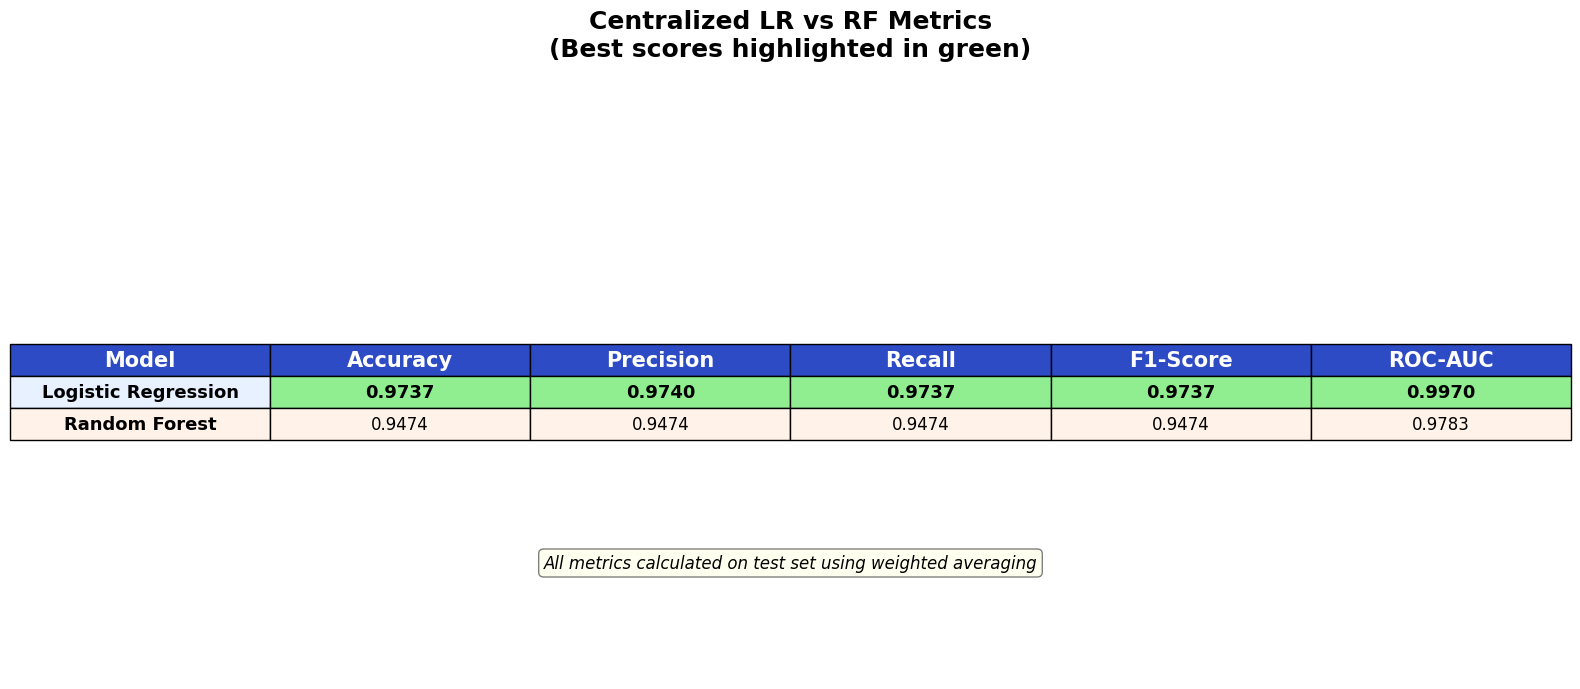

In [28]:
# Probability predictions for ROC-AUC
y_test_proba_lr = lr_model.predict_proba(X_test_final_scaled)
y_test_proba_rf = rf_model.predict_proba(X_test_final)

# Calculate metrics
lr_metrics = calculate_metrics(y_test_final, y_test_pred_lr, y_test_proba_lr)
rf_metrics = calculate_metrics(y_test_final, y_test_pred_rf, y_test_proba_rf)

# Comparison table
comprehensive_summary = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [f"{lr_metrics['accuracy']:.4f}", f"{rf_metrics['accuracy']:.4f}"],
    'Precision': [f"{lr_metrics['precision']:.4f}", f"{rf_metrics['precision']:.4f}"],
    'Recall': [f"{lr_metrics['recall']:.4f}", f"{rf_metrics['recall']:.4f}"],
    'F1-Score': [f"{lr_metrics['f1']:.4f}", f"{rf_metrics['f1']:.4f}"],
    'ROC-AUC': [f"{lr_metrics['roc_auc']:.4f}", f"{rf_metrics['roc_auc']:.4f}"]
}

comprehensive_df = pd.DataFrame(comprehensive_summary)

# -------------------------------- TABLE PLOT -------------------------------- #
# Dynamic sizing
num_rows = len(comprehensive_df)
num_cols = len(comprehensive_df.columns)
max_header_length = max(len(str(col)) for col in comprehensive_df.columns)
max_content_length = max([max(len(str(cell)) for cell in comprehensive_df[col]) for col in comprehensive_df.columns])

width = max(12, num_cols * 2.5 + max_header_length * 0.15)
height = max(6, num_rows * 2 + 3)

fig, ax = plt.subplots(figsize=(width, height))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=comprehensive_df.values,  #type: ignore
                colLabels=comprehensive_df.columns, #type: ignore
                cellLoc='center',
                loc='center')

# Dynamic font sizing
base_fontsize = max(10, min(14, 250 // max_content_length))
table.auto_set_font_size(False)
table.set_fontsize(base_fontsize)

# Dynamic table scaling
scale_x = max(1.2, min(2.0, width / 12))
scale_y = max(1.8, min(2.8, height / 6))
table.scale(scale_x, scale_y)

# Header styling
header_color = '#2E4BC6'
header_fontsize = min(base_fontsize + 2, 16)
for i in range(len(comprehensive_df.columns)):
    table[(0, i)].set_facecolor(header_color)
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=header_fontsize)

# Row styling with performance highlighting
model_colors = ['#E8F1FF', '#FFF2E8']
for i in range(1, len(comprehensive_df) + 1):
    # Model names column
    table[(i, 0)].set_facecolor(model_colors[i-1])
    table[(i, 0)].set_text_props(weight='bold', fontsize=base_fontsize)
    
    # Metric columns - highlight best performance
    for j in range(1, len(comprehensive_df.columns)):
        # Extract numeric values for comparison
        value = float(comprehensive_df.iloc[i-1, j])                                            #type: ignore
        col_values = [float(comprehensive_df.iloc[k, j]) for k in range(len(comprehensive_df))] #type: ignore
        is_best = value == max(col_values)
        
        if is_best:
            table[(i, j)].set_facecolor('#90EE90')
            table[(i, j)].set_text_props(weight='bold', fontsize=base_fontsize)
        else:
            table[(i, j)].set_facecolor(model_colors[i-1])
            table[(i, j)].set_text_props(fontsize=base_fontsize - 1)

# Title
title_fontsize = max(14, min(18, width * 1.2))
plt.title('Centralized LR vs RF Metrics\n(Best scores highlighted in green)', 
          fontsize=title_fontsize, fontweight='bold', pad=35)

# Subtitle
subtitle_fontsize = max(9, min(12, base_fontsize))
plt.figtext(0.5, 0.18, 'All metrics calculated on test set using weighted averaging', 
            ha='center', fontsize=subtitle_fontsize, style='italic',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.5))

plt.subplots_adjust(top=0.85, bottom=0.25)
plt.tight_layout()

# Save the plot
save_plot(fig, config['plots']['centralized_model']['centralized_lr_vs_rf_metrics'])

plt.show()

**Plots**

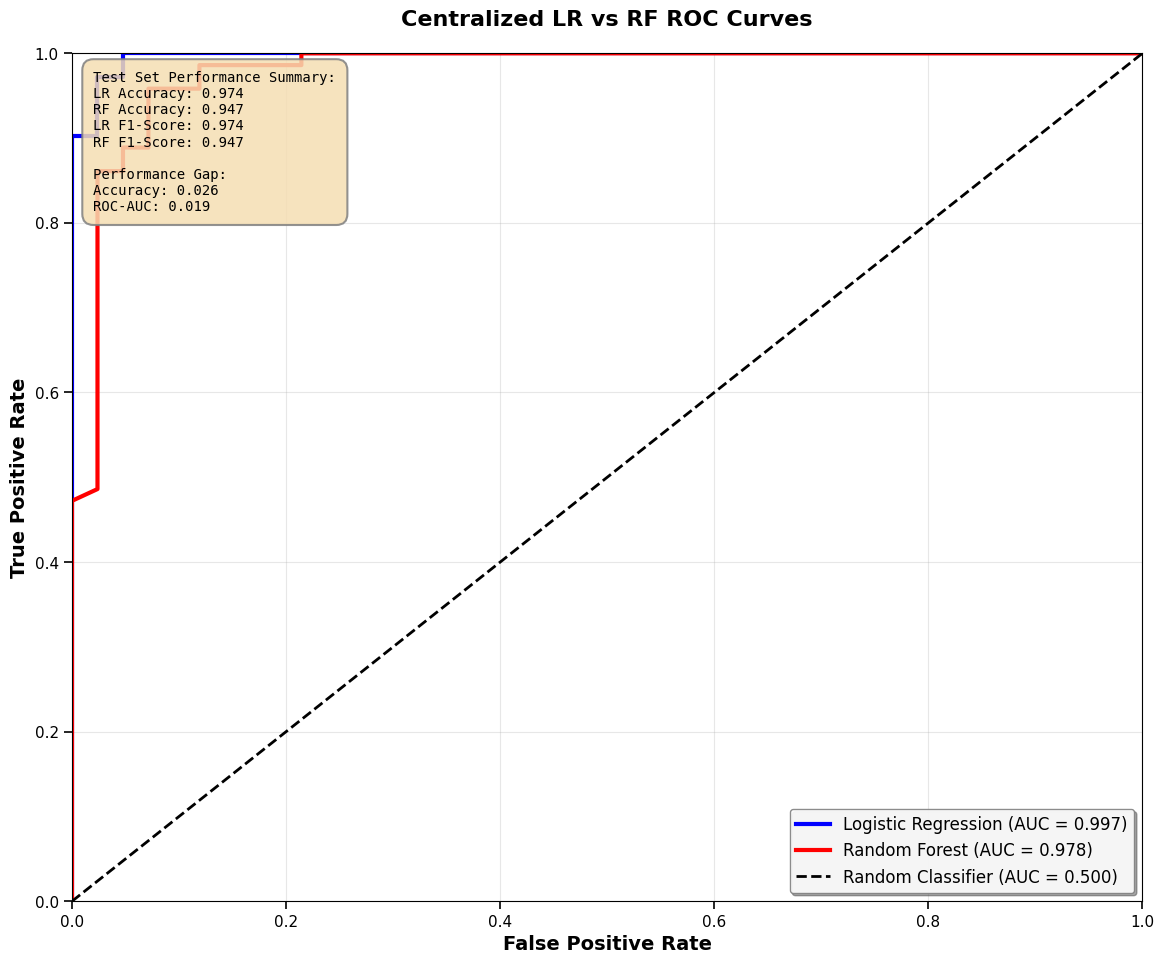

In [29]:
# ROC curves
fig, ax = plt.subplots(figsize=(12, 10))

# LR ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test_final, y_test_proba_lr[:, 1])
ax.plot(fpr_lr, tpr_lr, linewidth=3, label=f'Logistic Regression (AUC = {lr_metrics["roc_auc"]:.3f})', color='blue')

# RF ROC  
fpr_rf, tpr_rf, _ = roc_curve(y_test_final, y_test_proba_rf[:, 1])
ax.plot(fpr_rf, tpr_rf, linewidth=3, label=f'Random Forest (AUC = {rf_metrics["roc_auc"]:.3f})', color='red')

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

# Formatting
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 12
tick_fontsize = 11

ax.set_xlabel('False Positive Rate', fontsize=label_fontsize, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=label_fontsize, fontweight='bold')
ax.set_title('Centralized LR vs RF ROC Curves', fontsize=title_fontsize, fontweight='bold', pad=20)

# Legend
legend = ax.legend(fontsize=legend_fontsize, loc='lower right', 
                   frameon=True, fancybox=True, shadow=True, framealpha=0.9)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')

ax.grid(True, alpha=0.3, linewidth=0.8)
ax.set_xlim([0, 1])     #type: ignore
ax.set_ylim([0, 1])     #type: ignore

# Tick formatting
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, width=1.2, length=6)
ax.tick_params(axis='both', which='minor', width=0.8, length=4)

# Text box with key metrics
textstr = f'''Test Set Performance Summary:
LR Accuracy: {lr_metrics["accuracy"]:.3f}
RF Accuracy: {rf_metrics["accuracy"]:.3f}
LR F1-Score: {lr_metrics["f1"]:.3f}  
RF F1-Score: {rf_metrics["f1"]:.3f}

Performance Gap:
Accuracy: {abs(lr_metrics["accuracy"] - rf_metrics["accuracy"]):.3f}
ROC-AUC: {abs(lr_metrics["roc_auc"] - rf_metrics["roc_auc"]):.3f}'''

props = dict(boxstyle='round,pad=0.8', facecolor='wheat', alpha=0.85, edgecolor='gray', linewidth=1.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout(pad=2.0)

# Save ROC Curve Plot
save_plot(fig, config['plots']['centralized_model']['centralized_lr_vs_rf_roc_curves'])
plt.show()

**Compare Metrics**

In [30]:
print("Best Model Selection")

# Scoring system (higher is better)
lr_score = lr_metrics['accuracy'] + lr_metrics['precision'] + lr_metrics['recall'] + lr_metrics['f1'] + lr_metrics['roc_auc']
rf_score = rf_metrics['accuracy'] + rf_metrics['precision'] + rf_metrics['recall'] + rf_metrics['f1'] + rf_metrics['roc_auc']

print(f" Logistic Regression - Combined Score: {lr_score:.4f}")
print(f" Random Forest - Combined Score: {rf_score:.4f}")

# Best model
if rf_score > lr_score:
    best_model_name = "Random Forest"
    best_model_obj = rf_model
    best_model_metrics = rf_metrics
    best_scaler = None  # RF doesn't need scaling
else:
    best_model_name = "Logistic Regression"
    best_model_obj = lr_model
    best_model_metrics = lr_metrics
    best_scaler = scaler  # LR needs the scaler

print(f"\nBest Model: {best_model_name}")
print(f" Best Model Test Accuracy: {best_model_metrics['accuracy']:.4f}")
print(f" Best Model Test F1-Score: {best_model_metrics['f1']:.4f}")
print(f" Best Model Test ROC-AUC: {best_model_metrics['roc_auc']:.4f}")

Best Model Selection
 Logistic Regression - Combined Score: 4.8921
 Random Forest - Combined Score: 4.7678

Best Model: Logistic Regression
 Best Model Test Accuracy: 0.9737
 Best Model Test F1-Score: 0.9737
 Best Model Test ROC-AUC: 0.9970


**Save Best Model**

In [31]:
# Create models directory
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# Save the best model
best_model_path = os.path.join(models_dir, 'centralized_best.joblib')

# Save model with scaler if needed
model_package = {
    'model': best_model_obj,
    'model_name': best_model_name,
    'scaler': best_scaler,
    'metrics': best_model_metrics,
    'features': list(X_train_central.columns)
}

joblib.dump(model_package, best_model_path)
print(f"Best model saved to: {best_model_path}")
print(f"Model package includes: model, scaler (if needed), metrics, and feature names")

Best model saved to: ../models/centralized_best.joblib
Model package includes: model, scaler (if needed), metrics, and feature names


**Verify Model**

In [32]:
# Verification
print("Model Verification")
loaded_model_package = joblib.load(best_model_path)
loaded_model = loaded_model_package['model']
loaded_scaler = loaded_model_package['scaler']

# Test predictions
if loaded_scaler is not None:
    # For LR
    test_pred_verify = loaded_model.predict(loaded_scaler.transform(X_test_final))
else:
    # For RF
    test_pred_verify = loaded_model.predict(X_test_final)

verify_accuracy = accuracy_score(y_test_final, test_pred_verify)
print(f"Loaded model test accuracy: {verify_accuracy:.4f}")
print(f"Original model test accuracy: {best_model_metrics['accuracy']:.4f}")

if abs(verify_accuracy - best_model_metrics['accuracy']) < 1e-10:
  print("=== Verification PASSED ===")
else:
    raise ValueError("=== Verification FAILED - Accuracy mismatch ===")

Model Verification
Loaded model test accuracy: 0.9737
Original model test accuracy: 0.9737
=== Verification PASSED ===


## 4. Flower Model

In [34]:
! cd ../lunartech/ && flwr run

Loading project configuration... 
Success
Random seed set to 1
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=61827) Random seed set to 1
(ClientAppActor pid=61827) Random seed set to 1
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_ev